### Setup

In [1]:
cd /content/drive/MyDrive/fourier_neural_operator/

/content/drive/MyDrive/fourier_neural_operator


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torchvision.transforms import Normalize
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
import random
import time

torch.manual_seed(0)
np.random.seed(0)

### Model

In [3]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [4]:
################################################################
#  Load data
################################################################

data = np.load('data/KFvorticity_Re40_N200_T500.npy')
data = torch.tensor(data, dtype=torch.float)
print(data.shape)

torch.Size([200, 501, 64, 64])


### Train

In [ ]:
################################################################
#  Training configurations
################################################################

ntrain = 100
ntest = 10

sub = 4
s = int(data.shape[-1] / sub)

modes = 9
width = 16
batch_size = 5 

learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5
epochs = 500

In [ ]:
################################################################
#  Path
################################################################

path = 'KF_NS_2D' + '_N' + str(ntrain) + '_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

In [ ]:
################################################################
#  Dataset 1
################################################################

length = data.shape[0] * data.shape[1]

dataset = data.reshape(length, 64, 64)

x_train = dataset[:ntrain,::sub,::sub]
y_train = dataset[:ntrain,::sub,::sub]

x_test = dataset[-ntest:,::sub,::sub]
y_test = dataset[-ntest:,::sub,::sub]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s,s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

device = torch.device('cuda')

In [ ]:
################################################################
#  Dataset 2
################################################################

T = random.randint(1, data.shape[1])

x_train = data[:ntrain,T-1,::sub,::sub]
y_train = data[:ntrain,T,::sub,::sub]

x_test = data[-ntest:,T-1,::sub,::sub]
y_test = data[-ntest:,T,::sub,::sub]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s,s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

device = torch.device('cuda')

In [ ]:
################################################################
#  train
################################################################

model = FNO2d(modes, modes, width).cuda()
# print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s)
       
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)

    torch.save(model, path_model)

0 0.1756070120009099 0.746908495426178 0.48965446949005126
1 0.17051798600004986 0.4100786662101746 0.39800294637680056
2 0.17570594900098513 0.35544937252998354 0.39171379804611206
3 0.1663145069996972 0.35685471534729 0.4022871494293213
4 0.19131414200091967 0.3521394670009613 0.3928682804107666
5 0.17669646800095506 0.34641109108924867 0.39206156730651853
6 0.1749804770006449 0.3338624703884125 0.39142690896987914
7 0.17181800899925292 0.3327928125858307 0.3837910175323486
8 0.18373439499919186 0.3239989674091339 0.3757577180862427
9 0.16986358400026802 0.311492315530777 0.3798368453979492
10 0.19113817400102562 0.29675904154777527 0.37553335428237916
11 0.1709098039991659 0.2905351209640503 0.3667513370513916
12 0.178802190001079 0.2737447679042816 0.3685952663421631
13 0.17452388099991367 0.26335439205169675 0.3712342858314514
14 0.1751434670004528 0.24981213569641114 0.36629457473754884
15 0.17639684800087707 0.23748255252838135 0.36916770935058596
16 0.17178295700068702 0.224222

In [ ]:
# x_train = data[:ntrain,T_in-1:T_out-1,::sub,::sub].permute(0,2,3,1)
# y_train = data[:ntrain,T_in:T_out,::sub,::sub].permute(0,2,3,1)

# x_test = data[-ntest:,T_in-1:T_out-1,::sub,::sub].permute(0,2,3,1)
# y_test = data[-ntest:,T_in:T_out,::sub,::sub].permute(0,2,3,1)

# x_train = data[:ntrain,0,::sub,::sub].permute(0,2,3,1)
# y_train = data[:ntrain,1,::sub,::sub].permute(0,2,3,1)

# x_test = data[-ntest:,0,::sub,::sub].permute(0,2,3,1)
# y_test = data[-ntest:,1,::sub,::sub].permute(0,2,3,1)

# grids = []
# grids.append(np.linspace(0, 1, s))
# grids.append(np.linspace(0, 1, s))
# grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
# grid = grid.reshape(1,s,s,2)
# grid = torch.tensor(grid, dtype=torch.float)
# x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
# x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# x_normalizer = UnitGaussianNormalizer(x_train)
# x_train = x_normalizer.encode(x_train)
# x_test = x_normalizer.encode(x_test)

# y_normalizer = UnitGaussianNormalizer(y_train)
# y_train = y_normalizer.encode(y_train)

# gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, 1, 1])
# gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, 1, 1])

# x_train = torch.cat((gridx.repeat([ntrain, 1, 1, T, 1]), gridy.repeat([ntrain, 1, 1, T, 1]), 
#                      x_train.reshape(ntrain, S, S, T, 1)), dim=-1)
# x_test = torch.cat((gridx.repeat([ntest, 1, 1, T, 1]), gridy.repeat([ntest, 1, 1, T, 1]), 
#                     x_test.reshape(ntest, S, S, T, 1)), dim=-1)

# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
#                                            batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
#                                           batch_size=batch_size, shuffle=False)

# device = torch.device('cuda')

### Inverse

In [15]:
################################################################
#  Inverse configurations
################################################################

sub = 1
s = int(data.shape[-1] / sub)

learning_rate = 0.1
scheduler_step = 100
scheduler_gamma = 0.5
epochs = 5000

In [16]:
################################################################
# load data
################################################################

length = data.shape[0] * data.shape[1]

dataset = data.reshape(length, 64, 64)
T = random.randint(0, length-1)

x_groundtruth = dataset[T,::sub,::sub]
y = dataset[T+1,::sub,::sub]

grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s,s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_groundtruth = torch.cat([x_groundtruth.reshape(1,s,s,1), grid.repeat(1,1,1,1)], dim=3)

In [26]:
################################################################
# load model
################################################################

PATH = 'model/KF_NS_2D_N100_ep500_m9_w16'
model = torch.load(PATH)

#randomly generate parameters
x = torch.rand(x_groundtruth.shape, requires_grad=True, device="cuda")
# x = torch.norm(F.normalize(x_groundtruth, p=2, dim=1)).weight * torch.rand(x_groundtruth.shape, requires_grad=True).weight
y, x_groundtruth = y.cuda(), x_groundtruth.cuda()

optimizer = torch.optim.SGD([x], lr=learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
myloss = nn.MSELoss()

t0 = time.time()

for i in range(epochs):

    optimizer.zero_grad()
    output = model(x)
    loss = myloss(output.view(1, -1), y.view(1, -1))
    loss_groundtruth = myloss(x.view(1, -1), x_groundtruth.view(1, -1))

    loss.backward()
    # loss.backward(retain_graph=True)
    # loss_groundtruth.backward()
    
    optimizer.step()
    scheduler.step()

    print(i, loss.item())
    # print(i, loss.item(), loss_groundtruth.item())
    model.eval()

    ## noise generation
    # noise = x.clone()
    # noise = coef * learning_rate * torch.norm(noise) * torch.randn(x.shape, requires_grad=False, device="cuda")
    # x = x + noise

t1 = time.time()

print((t1-t0)/epochs)

0 5.457407474517822
1 5.456835746765137
2 5.45574951171875
3 5.454202175140381
4 5.452239036560059
5 5.449901103973389
6 5.447229385375977
7 5.4442596435546875
8 5.441030025482178
9 5.437570095062256
10 5.433893203735352
11 5.430026054382324
12 5.425989151000977
13 5.421793460845947
14 5.417479515075684
15 5.413064002990723
16 5.408557891845703
17 5.403968334197998
18 5.399297714233398
19 5.394564628601074
20 5.3897786140441895
21 5.384941101074219
22 5.380055904388428
23 5.375138282775879
24 5.370179176330566
25 5.3651885986328125
26 5.360176086425781
27 5.355164527893066
28 5.350165843963623
29 5.345174789428711
30 5.3401899337768555
31 5.335206031799316
32 5.330232620239258
33 5.325255393981934
34 5.320287704467773
35 5.315336227416992
36 5.310390472412109
37 5.305449485778809
38 5.300514221191406
39 5.295591354370117
40 5.290680885314941
41 5.285772800445557
42 5.28088903427124
43 5.276019096374512
44 5.27116584777832
45 5.266331195831299
46 5.261530876159668
47 5.256765365600586
4

KeyboardInterrupt: ignored

### Visualization

In [27]:
color = sns.diverging_palette(220, 20, as_cmap=True)

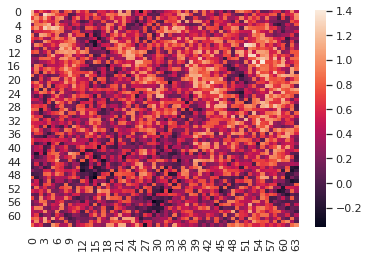

In [28]:
# Inverse x
x_plot = x[:,:,:,0]
x_plot = x_plot.cpu().detach().numpy()
x_plot = x_plot.reshape(s,s)
ax = sns.heatmap(x_plot)

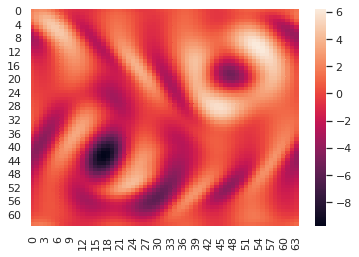

In [29]:
# Groundtruth x
x_groundtruth_plot = x_groundtruth[:,:,:,0]
x_groundtruth_plot = x_groundtruth_plot.cpu().detach().numpy()
x_groundtruth_plot = x_groundtruth_plot.reshape(s,s)
ax = sns.heatmap(x_groundtruth_plot)

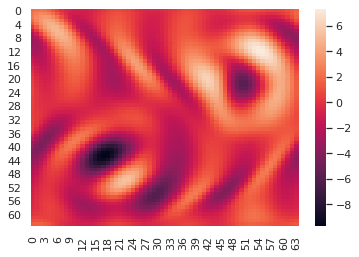

In [22]:
# Groundtruth y
y_plot = y.cpu().detach().numpy()
y_plot = y_plot.reshape(s,s)
ax = sns.heatmap(y_plot)

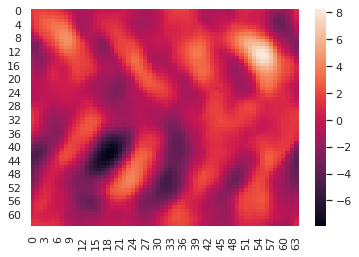

In [23]:
# Predict y from groundtruth x
y_predict_plot = model(x_groundtruth).cpu().detach().numpy()
y_predict_plot = y_predict_plot.reshape(s,s)
ax = sns.heatmap(y_predict_plot)

-0.5019342


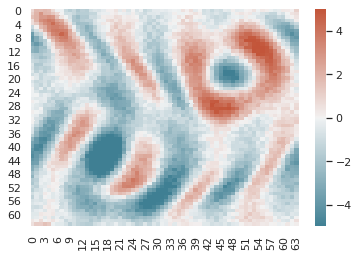

In [30]:
ax = sns.heatmap(x_groundtruth_plot - x_plot, vmin=-5, vmax=5, cmap = color)
print(np.mean(x_groundtruth_plot - x_plot))

0.04607027


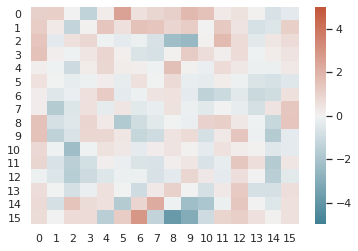

In [ ]:
ax = sns.heatmap(y_predict_plot - y_plot, vmin=-5, vmax=5, cmap = color)
print(np.mean(y_predict_plot - y_plot))